In [ ]:
import pandas as pd
pd.set_option('display.precision', 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras_tuner
import keras_tuner
from keras_tuner.engine.hyperparameters import HyperParameters

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from imageio import imread
from skimage.transform import resize
import cv2
from cv2 import IMREAD_GRAYSCALE,COLOR_BGR2GRAY
from google.colab.patches import cv2_imshow
import os
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.optimizers import Adam,SGD,RMSprop,Adadelta

In [ ]:
path= "/content/drive/MyDrive/Colab Notebooks/yenidata"


X_data = []
y_data = []
for subdir, dirs, files in os.walk(path):
   print(subdir)
   for file in files:
        pic = cv2.imread(os.path.join(subdir, file))
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
        pic = resize(pic, (96, 96,1))

        X_data.append(pic)
        y_data.append(int(subdir[-1]))



X = np.array(X_data) / 255
y = np.array(y_data)

print(X.shape)
print(y.shape)


/content/drive/MyDrive/Colab Notebooks/yenidata
/content/drive/MyDrive/Colab Notebooks/yenidata/0
/content/drive/MyDrive/Colab Notebooks/yenidata/0/.ipynb_checkpoints
/content/drive/MyDrive/Colab Notebooks/yenidata/.ipynb_checkpoints
/content/drive/MyDrive/Colab Notebooks/yenidata/1
(3000, 96, 96, 1)
(3000,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle =True)


print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")

print(f"X_train shape: {X_train.shape}")

print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

X_train: 2400
y_train: 2400
X_train shape: (2400, 96, 96, 1)
X_test: 600
y_test: 600


In [ ]:
def define_model(hp):

  model = tf.keras.Sequential()


  for i in range(hp.Int('katman_sayisi', min_value=1, max_value=5)):

    model.add(tf.keras.layers.Conv2D(
                                 filters =32,
                                 kernel_size=5,
                                 strides=(1,1),
                                 padding="same",
                                 activation=hp.Choice('activation1',values=["relu","elu","tanh","softmax"]),
                                 input_shape=(96, 96, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))


  model.add(tf.keras.layers.Flatten())


  model.add(tf.keras.layers.Dense(hp.Choice('Dense',values=[64,128,256,512]), activation=hp.Choice('activation2',values=["relu","elu","tanh","softmax"])))
  model.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.6, step = 0.1)))




# Add the output layer
  model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

  optimizer = hp.Choice('optimizer',values=["Adam","RMSprop","Adadelta","SGD"])

  if optimizer == 'Adam':
    optimizer = Adam(lr= hp.Choice('learning_rate', values=[1e-3, 1e-4]))
  elif optimizer == 'RMSprop':
    optimizer = RMSprop(lr= hp.Choice('learning_rate', values=[1e-3, 1e-4]))
  elif optimizer == 'Adadelta':
    optimizer = Adadelta(lr= hp.Choice('learning_rate', values=[1e-3, 1e-4]))
  elif optimizer == 'SGD':
    optimizer = SGD(lr= hp.Choice('learning_rate', values=[1e-3, 1e-4]))

  model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


  return model

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    define_model,
    objective='val_accuracy',
    max_trials=100,
    directory='.',
    project_name='tuning-mlp',
    overwrite = True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1,min_delta = 1e-3,mode="max",restore_best_weights=True)
callback2=  ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=1e-4)
callback = [callback1,callback2]
tuner.search(X_train, y_train,epochs=300,validation_split = 0.2,batch_size=64,callbacks=callback)

Trial 100 Complete [00h 00m 38s]
val_accuracy: 0.987500011920929

Best val_accuracy So Far: 0.9958333373069763
Total elapsed time: 01h 13m 54s


In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'katman_sayisi': 4, 'activation1': 'tanh', 'Dense': 128, 'activation2': 'relu', 'dropout': 0.30000000000000004, 'optimizer': 'Adam', 'learning_rate': 0.001}


In [ ]:
model = tuner.get_best_models()[0]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1,min_delta = 1e-5,mode="max",restore_best_weights=True)
callback2=  ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=1e-4)
callback = [callback1,callback2]
import time
t0 = time.time()
result= model.fit(X_train,y_train,validation_split=0.2,epochs=300,batch_size=64,callbacks=callback)
t1 = time.time()
elapsed = (t1-t0)

print()
print("Training Time: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")


Epoch 1/300
30/30 [==============================] - 1s 29ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0493 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 2/300
30/30 [==============================] - 1s 21ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0489 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 3/300
30/30 [==============================] - 1s 24ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0497 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 4/300
30/30 [==============================] - 1s 25ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0488 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 5/300
30/30 [==============================] - 1s 24ms/step - loss: 8.0598e-04 - accuracy: 1.0000 - val_loss: 0.0485 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 6/300
30/30 [==============================] - 1s 19ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0481 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 7/300
30/30 [=======================

In [ ]:
import time
t0 = time.time()
degerlendirme = model.evaluate(X_test, y_test)
t1 = time.time()
elapsed = (t1-t0)/600
print(f"loss değeri : {np.round(degerlendirme[0],3)}")
print(f"accuracy değeri : {np.round(degerlendirme[1],3)}\n")

print("bir gözlemin test edilmesi: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")

19/19 [==============================] - 0s 15ms/step - loss: 0.1437 - accuracy: 0.9750
loss değeri : 0.144
accuracy değeri : 0.975

bir gözlemin test edilmesi: 00:00:00:52 milisaniye


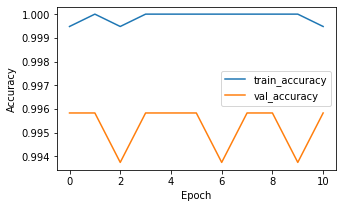

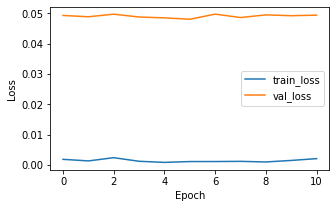

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))

# Plot the the training loss
plt.plot(result.history["accuracy"], label="train_accuracy")

# Plot the the validation loss
plt.plot(result.history["val_accuracy"], label="val_accuracy")


# Name the x and y axises
plt.ylabel("Accuracy")
plt.xlabel("Epoch")


# Put legend table
plt.legend()

# Show the plot
plt.show()

import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))

# Plot the the training loss
plt.plot(result.history["loss"], label="train_loss")

# Plot the the validation loss
plt.plot(result.history["val_loss"], label="val_loss")


# Name the x and y axises
plt.ylabel("Loss")
plt.xlabel("Epoch")


# Put legend table
plt.legend()

# Show the plot
plt.show()

19/19 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

    Tümörsüz       0.97      0.98      0.98       338
     Tümörlü       0.98      0.97      0.97       262

    accuracy                           0.97       600
   macro avg       0.98      0.97      0.97       600
weighted avg       0.98      0.97      0.97       600





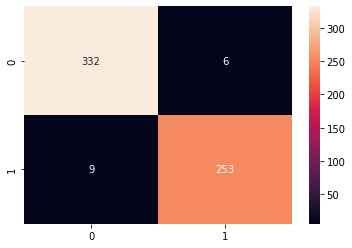

In [ ]:
prediction1 = model.predict(X_test)
prediction = np.argmax(prediction1,axis=1)

from sklearn.metrics import classification_report


rapor = classification_report(y_test,prediction,target_names = ["Tümörsüz","Tümörlü"])

print(rapor)

print()
print()

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, prediction)
f = sns.heatmap(cm, annot=True,fmt='d')


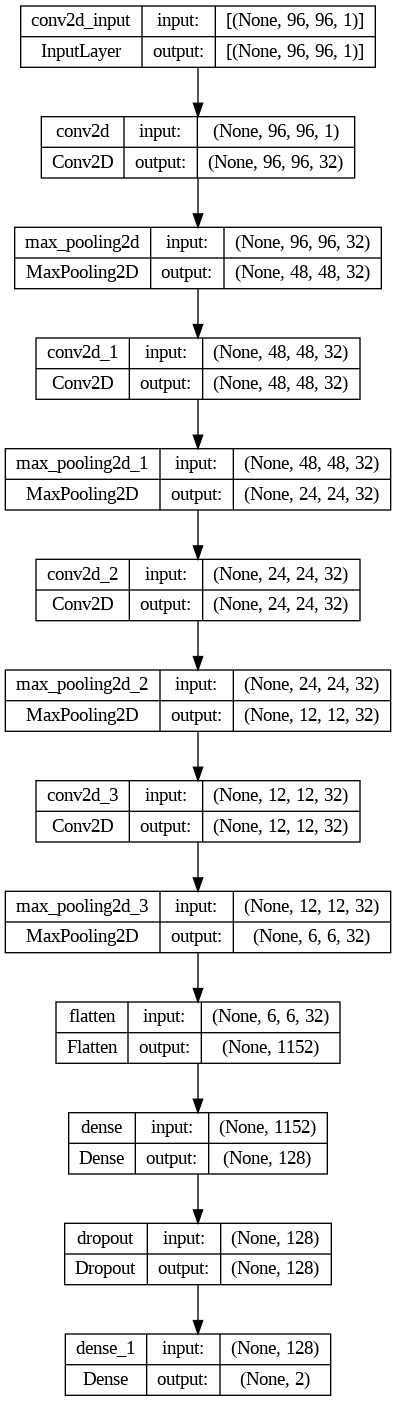

In [ ]:
from keras.utils import plot_model
import numpy as np

plot_model(model, to_file='model.png', show_shapes=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


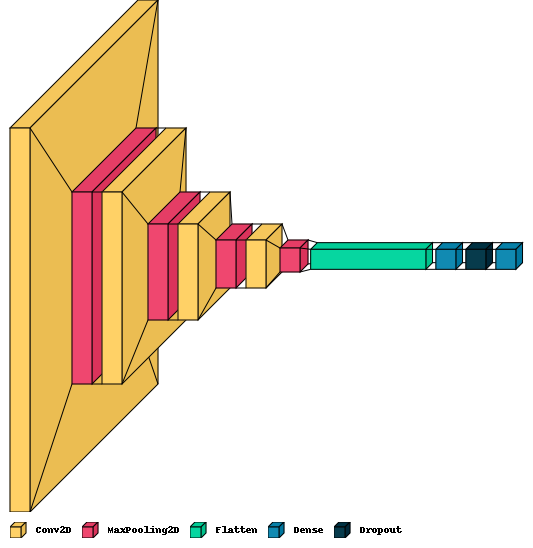

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend = True)

In [ ]:
for i in range(len(model.layers)):
	# check for convolutional layer
	if 'conv' not in model.layers[i].name:
		continue
	# get filter weights
	filters, biases = model.layers[i].get_weights()
	print("layer number",i,model.layers[i].name, filters.shape)

layer number 0 conv2d (5, 5, 1, 32)
layer number 2 conv2d_1 (5, 5, 32, 32)
layer number 4 conv2d_2 (5, 5, 32, 32)
layer number 6 conv2d_3 (5, 5, 32, 32)


In [ ]:
from tensorflow.keras.utils import load_img,img_to_array

image = load_img("/content/drive/MyDrive/Colab Notebooks/pred9.jpg" , target_size=(96,96))

# convert the image to an array
image = img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = tf.expand_dims(image, axis=0)
#image.reshape((1,96,96,3))
print(image.shape)
image= image/255


(1, 96, 96, 3)



##############################################conv2d#################################################

1/1 [==============================] - 0s 59ms/step


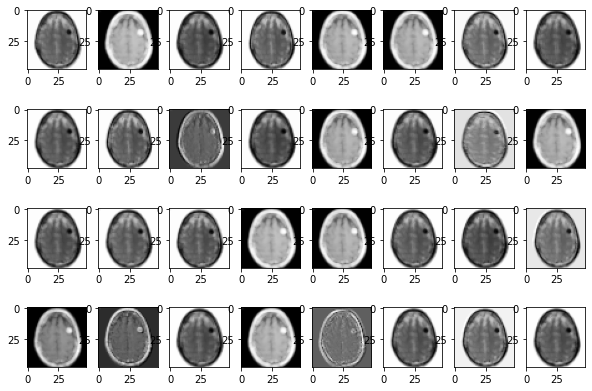


##############################################conv2d_1#################################################

1/1 [==============================] - 0s 94ms/step


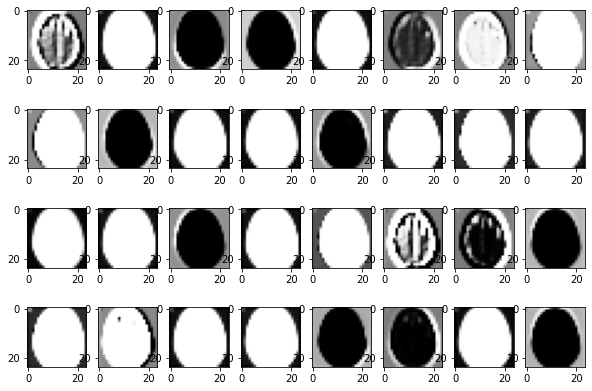


##############################################conv2d_2#################################################

1/1 [==============================] - 0s 102ms/step


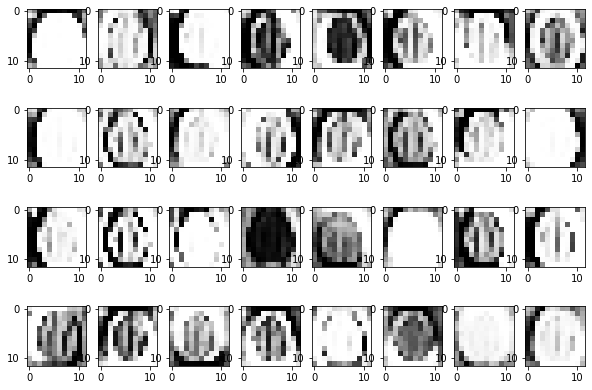


##############################################conv2d_3#################################################



1/1 [==============================] - 0s 161ms/step


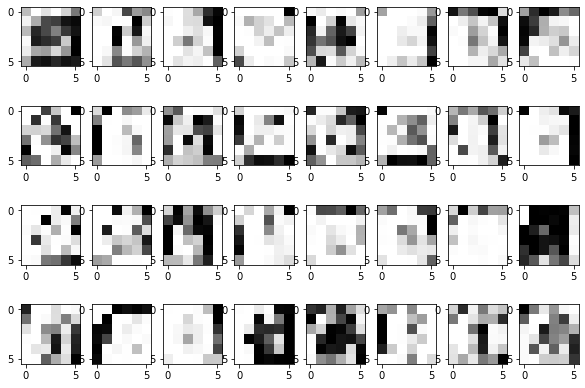

In [ ]:
layers = [1,3,5,7]
from keras.models import Model
for i in layers:
  model2 = Model(inputs=model.inputs , outputs=model.layers[i].output)
  print()
  print(f"##############################################{model2.layers[i].name}#################################################\n")
  features = model2.predict(resize(image, (1,96, 96,1)))

  fig = plt.figure(figsize=(10,7))
  for i in range(1,features.shape[3]+1):

    plt.subplot(4,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')


  plt.show()


------------------------------------------------------------

CROSS VALIDATION

In [ ]:
def create_model():

  model = tf.keras.Sequential()


  for i in range(4):

    model.add(tf.keras.layers.Conv2D(
                                 filters =32,
                                 kernel_size=5,
                                 strides=(1,1),
                                 padding="same",
                                 activation="tanh",
                                 input_shape=(96, 96, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))


  model.add(tf.keras.layers.Flatten())


  model.add(tf.keras.layers.Dense(128, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.3))




# Add the output layer
  model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

  optimizer =Adam(lr=0.001)

  model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


  return model

In [ ]:
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier

callback1_ = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10,verbose=1,min_delta = 1e-3,mode="max",restore_best_weights=True)
callback2_ =  ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=10, min_lr=1e-4)
callback_ = [callback1_,callback2_]


model = KerasClassifier(build_fn= create_model,epochs =300 ,batch_size=64,verbose=2 ,callbacks=callback_)

scores = cross_val_score(model,X_train,y_train,cv=3,scoring="accuracy")

<ipython-input-41-4e8b04727217>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn= create_model,epochs =300 ,batch_size=64,verbose=2 ,callbacks=callback_)
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
25/25 - 1s - loss: 0.6882 - accuracy: 0.5431 - lr: 0.0010 - 1s/epoch - 45ms/step
Epoch 2/300
25/25 - 0s - loss: 0.6231 - accuracy: 0.6556 - lr: 0.0010 - 376ms/epoch - 15ms/step
Epoch 3/300
25/25 - 0s - loss: 0.5356 - accuracy: 0.7250 - lr: 0.0010 - 377ms/epoch - 15ms/step
Epoch 4/300
25/25 - 0s - loss: 0.5055 - accuracy: 0.7456 - lr: 0.0010 - 377ms/epoch - 15ms/step
Epoch 5/300
25/25 - 0s - loss: 0.4684 - accuracy: 0.7862 - lr: 0.0010 - 374ms/epoch - 15ms/step
Epoch 6/300
25/25 - 0s - loss: 0.4204 - accuracy: 0.8125 - lr: 0.0010 - 375ms/epoch - 15ms/step
Epoch 7/300
25/25 - 0s - loss: 0.3862 - accuracy: 0.8288 - lr: 0.0010 - 370ms/epoch - 15ms/step
Epoch 8/300
25/25 - 0s - loss: 0.2714 - accuracy: 0.8894 - lr: 0.0010 - 368ms/epoch - 15ms/step
Epoch 9/300
25/25 - 0s - loss: 0.2335 - accuracy: 0.9125 - lr: 0.0010 - 380ms/epoch - 15ms/step
Epoch 10/300
25/25 - 0s - loss: 0.1817 - accuracy: 0.9281 - lr: 0.0010 - 382ms/epoch - 15ms/step
Epoch 11/300
25/25 - 0s - loss: 0.1341 - a

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
25/25 - 1s - loss: 0.6905 - accuracy: 0.5306 - lr: 0.0010 - 1s/epoch - 44ms/step
Epoch 2/300
25/25 - 0s - loss: 0.6826 - accuracy: 0.5619 - lr: 0.0010 - 401ms/epoch - 16ms/step
Epoch 3/300
25/25 - 0s - loss: 0.6091 - accuracy: 0.6819 - lr: 0.0010 - 401ms/epoch - 16ms/step
Epoch 4/300
25/25 - 0s - loss: 0.5076 - accuracy: 0.7613 - lr: 0.0010 - 402ms/epoch - 16ms/step
Epoch 5/300
25/25 - 0s - loss: 0.4243 - accuracy: 0.8056 - lr: 0.0010 - 398ms/epoch - 16ms/step
Epoch 6/300
25/25 - 0s - loss: 0.3514 - accuracy: 0.8462 - lr: 0.0010 - 399ms/epoch - 16ms/step
Epoch 7/300
25/25 - 1s - loss: 0.2509 - accuracy: 0.9019 - lr: 0.0010 - 559ms/epoch - 22ms/step
Epoch 8/300
25/25 - 1s - loss: 0.1791 - accuracy: 0.9344 - lr: 0.0010 - 774ms/epoch - 31ms/step
Epoch 9/300
25/25 - 1s - loss: 0.1352 - accuracy: 0.9463 - lr: 0.0010 - 695ms/epoch - 28ms/step
Epoch 10/300
25/25 - 0s - loss: 0.1325 - accuracy: 0.9506 - lr: 0.0010 - 467ms/epoch - 19ms/step
Epoch 11/300
25/25 - 0s - loss: 0.1090 - a

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
25/25 - 1s - loss: 0.6911 - accuracy: 0.5219 - lr: 0.0010 - 1s/epoch - 44ms/step
Epoch 2/300
25/25 - 0s - loss: 0.6107 - accuracy: 0.6744 - lr: 0.0010 - 375ms/epoch - 15ms/step
Epoch 3/300
25/25 - 0s - loss: 0.5492 - accuracy: 0.7225 - lr: 0.0010 - 373ms/epoch - 15ms/step
Epoch 4/300
25/25 - 0s - loss: 0.4857 - accuracy: 0.7869 - lr: 0.0010 - 373ms/epoch - 15ms/step
Epoch 5/300
25/25 - 0s - loss: 0.4292 - accuracy: 0.8056 - lr: 0.0010 - 373ms/epoch - 15ms/step
Epoch 6/300
25/25 - 0s - loss: 0.3654 - accuracy: 0.8263 - lr: 0.0010 - 372ms/epoch - 15ms/step
Epoch 7/300
25/25 - 0s - loss: 0.2927 - accuracy: 0.8819 - lr: 0.0010 - 373ms/epoch - 15ms/step
Epoch 8/300
25/25 - 0s - loss: 0.2215 - accuracy: 0.9156 - lr: 0.0010 - 371ms/epoch - 15ms/step
Epoch 9/300
25/25 - 0s - loss: 0.1791 - accuracy: 0.9275 - lr: 0.0010 - 370ms/epoch - 15ms/step
Epoch 10/300
25/25 - 0s - loss: 0.1305 - accuracy: 0.9500 - lr: 0.0010 - 374ms/epoch - 15ms/step
Epoch 11/300
25/25 - 0s - loss: 0.1084 - a

In [ ]:
print(f"1-Fold: {scores[0]}")
print(f"2-Fold: {scores[1]}")
print(f"3-Fold: {scores[2]}")
print()
print(f"ortalama accuracy değeri : {scores.mean()}")

1-Fold: 0.9725
2-Fold: 0.98
3-Fold: 0.9875

ortalama accuracy değeri : 0.9800000000000001
